<a href="https://colab.research.google.com/github/embarced/notebooks/blob/master/deep/binary-metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metrics on binary classifications


In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.4.1'

In [2]:
tf.random.set_seed(42)

In [3]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve

In [4]:
from lrcurve import KerasLearningCurve

In [5]:
# notebook does not need GPU, but we could turn it on any time
!nvidia-smi

Sat May  8 16:38:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (12, 12)

In [8]:
font_size=15
title_font_size=25

In [9]:
!pip install colour

In [10]:
# %config InlineBackend.figure_format = 'svg'

In [11]:
#@title Hidden code for plotting of decision boundaries taken from dtreeviz
# copied and adapted from
# https://github.com/parrt/dtreeviz/blob/class-boundary-viz/dtreeviz/classifiers.py
# need to use lib after changes have been merged

import numpy as np
import pandas as pd

import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from colour import Color
from PIL import ImageColor

YELLOW = '#fefecd'
GREEN = '#cfe2d4'
DARKBLUE = '#313695'
BLUE = '#4575b4'
DARKGREEN = '#006400'
LIGHTORANGE = '#fee090'
LIGHTBLUE = '#a6bddb'
GREY = '#444443'
WEDGE_COLOR = GREY
CATEGORICAL_SPLIT_LEFT= '#FFC300'
CATEGORICAL_SPLIT_RIGHT = BLUE

HIGHLIGHT_COLOR = '#D67C03'

color_blind_friendly_colors = [
    None,  # 0 classes
    None,  # 1 class
    ['#FEFEBB', '#a1dab4'],  # 2 classes
    ['#FEFEBB', '#D9E6F5', '#a1dab4'],  # 3 classes
    ['#FEFEBB', '#D9E6F5', '#a1dab4', LIGHTORANGE],  # 4
    ['#FEFEBB', '#D9E6F5', '#a1dab4', '#41b6c4', LIGHTORANGE],  # 5
    ['#FEFEBB', '#c7e9b4', '#41b6c4', '#2c7fb8', LIGHTORANGE, '#f46d43'],  # 6
    ['#FEFEBB', '#c7e9b4', '#7fcdbb', '#41b6c4', '#225ea8', '#fdae61', '#f46d43'],  # 7
    ['#FEFEBB', '#edf8b1', '#c7e9b4', '#7fcdbb', '#1d91c0', '#225ea8', '#fdae61', '#f46d43'],  # 8
    ['#FEFEBB', '#c7e9b4', '#41b6c4', '#74add1', BLUE, DARKBLUE, LIGHTORANGE, '#fdae61', '#f46d43'],  # 9
    ['#FEFEBB', '#c7e9b4', '#41b6c4', '#74add1', BLUE, DARKBLUE, LIGHTORANGE, '#fdae61', '#f46d43', '#d73027']  # 10
]

COLORS = {'scatter_edge': GREY,
          'scatter_marker': BLUE,
          'scatter_marker_alpha': 0.7,
          'class_boundary' : GREY,
          'warning' : '#E9130D',
          'tile_alpha':0.8,            # square tiling in clfviz to show probabilities
          'tesselation_alpha': 0.3,    # rectangular regions for decision tree feature space partitioning
          'tesselation_alpha_3D': 0.5,
          'split_line': GREY,
          'mean_line': '#f46d43',
          'axis_label': GREY,
          'title': GREY,
          'legend_title': GREY,
          'legend_edge': GREY,
          'edge': GREY,
          'color_map_min': '#c7e9b4',
          'color_map_max': '#081d58',
          'classes': color_blind_friendly_colors,
          'rect_edge': GREY,
          'text': GREY,
          'highlight': HIGHLIGHT_COLOR,
          'wedge': WEDGE_COLOR,
          'text_wedge': WEDGE_COLOR,
          'arrow': GREY,
          'node_label': GREY,
          'tick_label': GREY,
          'leaf_label': GREY,
          'pie': GREY,
          'hist_bar': LIGHTBLUE,
          'categorical_split_left': CATEGORICAL_SPLIT_LEFT,
          'categorical_split_right': CATEGORICAL_SPLIT_RIGHT
          }


def adjust_colors(colors):
    if colors is None:
        return COLORS
    return dict(COLORS, **colors)

import numpy as np
import pandas as pd

import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from colour import Color
from PIL import ImageColor

def clfviz_bivar(model, X:np.ndarray, y:np.ndarray,
                 ntiles=50, tile_fraction=.9,
                 binary_threshold=0.5,
                 show=['instances','boundaries','probabilities','misclassified'], # also 'legend'
                 feature_names=None, target_name=None, class_names=None,
                 markers=None,
                 boundary_marker='o', boundary_markersize=.8,
                 fontsize=9, fontname="Arial",
                 dot_w=25, colors:dict=None,
                 ax=None) -> None:
    """
    See comment and parameter descriptions for clfviz() above.
    """
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values

    if len(X.shape)==1 or (len(X.shape)==2 and X.shape[1]!=2) or len(X.shape)>2:
        raise ValueError(f"Expecting 2D data not {X.shape}")

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))

    # Created grid over the range of x1 and x2 variables, get probabilities, predictions
    grid_points, grid_proba, grid_pred_as_matrix, w, x_, class_X, class_values = \
        _compute_tiling(model, X, y, binary_threshold, ntiles, tile_fraction)

    x_proba = _predict_proba(model, X)
    if len(np.unique(y)) == 2:  # is k=2 binary?
        X_pred = np.where(x_proba[:, 1] >= binary_threshold, 1, 0)
    else:
        X_pred = np.argmax(x_proba, axis=1)  # TODO: assumes classes are 0..k-1
    class_X_pred = [X_pred[y == cl] for cl in class_values]

    if markers is None:
        markers = ['o']*len(class_X)

    colors = adjust_colors(colors)

    class_values = np.unique(y) # returns sorted

    # Get class to color map for probabilities and predictions
    color_map, grid_pred_colors, grid_proba_colors = \
        _get_grid_colors(grid_proba, grid_pred_as_matrix, class_values, colors)

    # Draw probabilities or class prediction grid
    facecolors = grid_proba_colors if 'probabilities' in show else grid_pred_colors
    _draw_tiles(ax, grid_points, facecolors, colors['tile_alpha'], x_, w)

    # Get grid with class predictions with coordinates (x,y)
    # e.g., y_pred[0,0] is lower left pixel and y_pred[5,5] is top-right pixel
    # for npoints=5
    grid_pred_as_matrix = grid_pred_as_matrix.reshape(ntiles, ntiles)

    if 'boundaries' in show:
        _draw_boundary_edges(ax, grid_points, grid_pred_as_matrix,
                             boundary_marker, boundary_markersize,
                             colors, w, x_)

    # Draw the X instances circles
    if 'instances' in show:
        for i, x_ in enumerate(class_X):
            if 'misclassified' in show:
                # Show correctly classified markers
                good_x = x_[class_X_pred[i] == class_values[i],:]
                ax.scatter(good_x[:, 0], good_x[:, 1],
                           s=dot_w, c=color_map[i],
                           marker=markers[i],
                           alpha=colors['scatter_marker_alpha'],
                           edgecolors=colors['scatter_edge'],
                           lw=.5)
                # Show misclassified markers (can't have alpha per marker so do in 2 calls)
                bad_x = x_[class_X_pred[i] != class_values[i],:]
                ax.scatter(bad_x[:, 0], bad_x[:, 1],
                           s=dot_w, c=color_map[i],
                           marker=markers[i],
                           alpha=1.0,
                           edgecolors=colors['warning'],
                           lw=.5)
            else:
                ax.scatter(x_[:, 0], x_[:, 1],
                           s=dot_w, c=color_map[i],
                           marker=markers[i],
                           alpha=colors['scatter_marker_alpha'],
                           edgecolors=colors['scatter_edge'],
                           lw=.5)

    if feature_names is not None:
        ax.set_xlabel(f"{feature_names[0]}", fontsize=fontsize, fontname=fontname, color=colors['axis_label'])
        ax.set_ylabel(f"{feature_names[1]}", fontsize=fontsize, fontname=fontname, color=colors['axis_label'])

    if 'legend' in show:
        class_names = utils._normalize_class_names(class_names, nclasses=len(class_values))
        add_classifier_legend(ax, class_names, class_values, color_map, target_name, colors)

    ax.tick_params(axis='both', which='major', width=.3, labelcolor=colors['tick_label'],
                   labelsize=fontsize)
    for tick in ax.get_xticklabels():
        tick.set_fontname(fontname)
    for tick in ax.get_yticklabels():
        tick.set_fontname(fontname)
    ax.spines['top'].set_visible(False)  # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)

def _compute_tiling(model, X:np.ndarray, y:np.ndarray, binary_threshold,
                    ntiles, tile_fraction):
    """
    Create grid over the range of x1 and x2 variables; use the model to
    compute the probabilities with model.predict_proba(), which will work with sklearn
    and, I think, XGBoost. Later we will have to figure out how to get probabilities
    out of the other models we support.

    The predictions are computed simply by picking the argmax of probabilities, which
    assumes classes are 0..k-1. TODO: update to allow disjoint integer class values

    For k=2 binary classifications, there is no way to set the threshold and so
    a threshold of 0.5 is implicitly chosen by argmax.

    This returns all of the details needed to plot the tiles. The coordinates of
    the grid are a linear space from min to max of each variable, inclusively.
    So if the range is 1..5 and we want 5 tiles, then the width of each tile is 1.
    We get a tile at each position. When we are drawing, the position is taken as
    the center of the tile. In this case, the grid points would be centered over
    1,2,3,4, and 5.
    """
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values

    X1 = X[:, 0]
    X2 = X[:, 1]
    x1r = max(X1) - min(X1)
    x2r = max(X2) - min(X2)
    border1 = x1r*0.05 # make a 5% border
    border2 = x2r*0.05
    x1range = (min(X1)-border1, max(X1)+border1)
    x2range = (min(X2)-border2, max(X2)+border2)
    w = (x1r+2*border1) / (ntiles-1)
    h = (x2r+2*border2) / (ntiles-1)
    w *= tile_fraction
    h *= tile_fraction

    grid_points = []  # a list of coordinate pairs for the grid
    # Iterate through v1 (x-axis) most quickly then v2 (y-axis)
    for iv2, v2 in enumerate(np.linspace(*x2range, num=ntiles, endpoint=True)):
        for iv1, v1 in enumerate(np.linspace(*x1range, num=ntiles, endpoint=True)):
            grid_points.append([v1, v2])
    grid_points = np.array(grid_points)

    class_values = np.unique(y)
    class_X = [X[y == cl] for cl in class_values]

    grid_proba = _predict_proba(model, grid_points)

    if len(np.unique(y))==2: # is k=2 binary?
        grid_pred = np.where(grid_proba[:,1]>=binary_threshold,1,0)
    else:
        grid_pred = np.argmax(grid_proba, axis=1) # TODO: assumes classes are 0..k-1

    return grid_points, grid_proba, grid_pred, w, h, class_X, class_values


def _get_grid_colors(grid_proba, grid_pred, class_values, colors):
    """
    For the grid locations, return a list of colors, one per location
    indicating the class color.  To compute the probability color,
    we want to simulate overlaying regions from multiple trees onto
    the two-dimensional feature space using alpha to shade the colors.
    Instead, compute the color for each tile by combining the class colors
    according to their probabilities. If class 1 has probability .3 and class 2
    has probability .7, multiply the color ((R,G,B) color vector) associated
    with class 1 by .3 and the color vector associated with class 2 by .7 then
    add together. This gives a weighted color vector for each tile associated with
    the class probabilities. This gives the exact same effect as alpha channels,
    but transparent colors screwed up plotting the instance circles on top; they
    got washed out. This gives us more control and we can use alpha=1.
    """
    nclasses = len(class_values)
    class_colors = np.array(colors['classes'][nclasses])

    grid_pred_colors = class_colors[grid_pred] # color for each prediction in grid

    color_map = {v: class_colors[i] for i, v in enumerate(class_values)}
    # multiply each probability vector times rgb color for each class then add
    # together to get weighted color
    rgb = np.array([ImageColor.getcolor(c, mode="RGB") for c in class_colors])
    grid_proba_colors = grid_proba @ rgb
    grid_proba_colors /= 255  # get in [0..1]
    grid_proba_colors = [Color(rgb=c).hex for c in grid_proba_colors]
    return color_map, grid_pred_colors, grid_proba_colors


def _draw_tiles(ax, grid_points, facecolors, tile_alpha, h, w):
    boxes = []
    for i, (v1, v2) in enumerate(grid_points):
        # center a box over (v1,v2) grid location
        rect = patches.Rectangle((v1 - w / 2, v2 - h / 2), w, h, angle=0.0, linewidth=0,
                                 facecolor=facecolors[i], alpha=tile_alpha)
        boxes.append(rect)
    # Adding collection is MUCH faster than repeated add_patch()
    ax.add_collection(PatchCollection(boxes, match_original=True))


def _draw_boundary_edges(ax, grid_points, grid_pred_as_matrix, boundary_marker, boundary_markersize,
                         colors, w, h):
    ntiles = grid_pred_as_matrix.shape[0]

    # find transitions from one class to the other moving horizontally
    dx = np.diff(grid_pred_as_matrix, axis=1)
    dx = np.abs(dx)
    # put a zero col vector on the left to restore size
    dx = np.hstack([np.zeros((ntiles, 1)), dx])

    # find transitions moving vertically, bottom to top (grid matrix is flipped vertically btw)
    dy = np.diff(grid_pred_as_matrix, axis=0)
    dy = np.abs(dy)
    # put a zero row vector on the top to restore size
    dy = np.vstack([np.zeros((1, ntiles)), dy])

    dx_edge_idx = np.where(dx.reshape(-1)) # what are the indexes of dx class transitions?
    dy_edge_idx = np.where(dy.reshape(-1)) # what are the indexes of dy class transitions?
    dx_edges = grid_points[dx_edge_idx]    # get v1,v2 coordinates of left-to-right transitions
    dy_edges = grid_points[dy_edge_idx]    # get v1,v2 coordinates of bottom-to-top transitions

    # Plot the boundary markers in between tiles; e.g., shift dx stuff to the left half a tile
    ax.plot(dx_edges[:, 0] - w / 2, dx_edges[:, 1], boundary_marker,
            markersize=boundary_markersize, c=colors['class_boundary'], alpha=1.0)
    ax.plot(dy_edges[:, 0], dy_edges[:, 1] - h / 2, boundary_marker,
            markersize=boundary_markersize, c=colors['class_boundary'], alpha=1.0)

def _predict_proba(model, X):
    """
    This is where we figure out how to get a matrix of k probabilities for a k-class
    classification problem.  It works with any model that answers predict_proba()
    but we can add special cases such as Keras, that has deprecated that method.
    """
    if len(X.shape)==1:
        X = X.reshape(-1,1)
    # Keras wants predict not predict_proba and still gives probabilities
    if model.__class__.__module__.startswith('tensorflow.python.keras'):
        proba = model.predict(X)
        if proba.shape[1]==1:
            proba = np.clip(proba, 0, 1)
            proba = np.hstack([1-proba,proba]) # get prob y=0, y=1 nx2 matrix like sklearn
        return proba

    # sklearn etc...
    return model.predict_proba(X)


# Predicting a category

* we want to infer which category a point in 2d belongs to
* this is called a classification
* since we only have two categories (0/1 or red/blue) this is called a binary classification

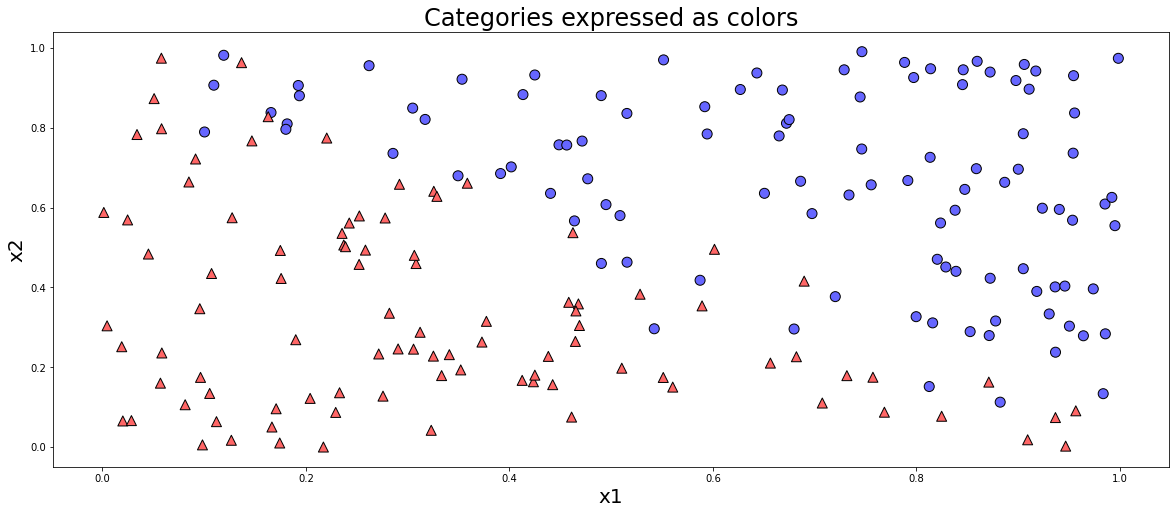

In [12]:
#@title Configure our example { run: "auto", display-mode: "form" }

# https://colab.research.google.com/notebooks/forms.ipynb

n = 200 #@param {type:"slider", min:1, max:1000, step:1}
m = -1 #@param {type:"slider", min:-10, max:10, step: 0.1}
b = 1 #@param {type:"slider", min:-10, max:10, step: 0.1}

noise_level = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.1}

title = 'Categories expressed as colors' #@param {type:"string"}
dim_1_label = 'x1' #@param {type:"string"}
dim_2_label = 'x2' #@param {type:"string"}

import pandas as pd
import numpy as np

# np.random.seed(42)

# all points
X = np.random.uniform(0, 1, (n, 2))

# below or above line determines which category they belong to (plus noise)
noise = np.random.normal(0, noise_level, n)
y_bool = X[:, 1] > m*X[:, 0]+b + noise
y = y_bool.astype(int)

plt.xlabel(dim_1_label)
plt.ylabel(dim_2_label)
plt.title(title)

size=100

from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#FF6666', '#6666FF'])

plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap, marker='o', edgecolors='k', s=y*size);
plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap, marker='^', edgecolors='k', s=~y_bool*size);

x = tf.constant(X, dtype='float32')
y_true = tf.constant(y, dtype='float32')

def plot_decision_boundaries(model, X, y_true):
  _, ax = plt.subplots(figsize=(8,4), dpi=300)

  clfviz_bivar(
              model, X, y_true, 
             show=['instances', 'boundaries', 'probabilities', 'misclassified'],
             markers=['^','o'],
             ntiles=50, 
             ax=ax,
             tile_fraction=1.0, 
             boundary_markersize=1.0,
             feature_names=[dim_1_label, dim_1_label],
             colors={'class_boundary': 'black',
                     'tile_alpha': 0.5,
                     'warning' : 'yellow',
                     'classes':
                         [None,  # 0 classes
                          None,  # 1 class
                          ['#FF6666', '#6666FF'],  # 2 classes
                          ]})

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160, 2), (40, 2), (160,), (40,))

In [14]:
%%time 
 
EPOCHS=500    

optimizer = tf.keras.optimizers.Adam()     

from tensorflow.keras.layers import Dense    

model = tf.keras.Sequential()
model.add(Dense(units=100, input_dim=2, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 56.8 s, sys: 2.76 s, total: 59.5 s
Wall time: 1min 2s


## Binary Metrics

* https://en.wikipedia.org/wiki/Precision_and_recall
* https://en.wikipedia.org/wiki/F1_score

### Most typical metrics

* _Precision_: ability not to label a sample as positive (1) that is negative (0)

* _Recall_: ability to find all the positive (1) samples

* _F1-Score_
  * harmonic mean of the precision and recall
  * harmonic mean is a good mean for ratios
  * best value at 1 and worstat 0

* _Support_: number of occurrences of samples for each class


In [15]:
# TensorFlow: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/metrics
# Scikit-learn: https://scikit-learn.org/stable/modules/model_evaluation.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

from sklearn.metrics import precision_recall_fscore_support, classification_report


### Scores for sigmode model with cross entropy, higher is better

In [16]:
y_pred_model_sigmoid_crossentropy = model.predict(x)


In [17]:
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, (y_pred_model_sigmoid_crossentropy > 0.5).astype(int).reshape(-1))
precision, recall, f1_score, support

(array([0.96666667, 0.91818182]),
 array([0.90625   , 0.97115385]),
 array([0.93548387, 0.94392523]),
 array([ 96, 104]))

In [18]:
print(classification_report(y_true, (y_pred_model_sigmoid_crossentropy > 0.5).astype(int).reshape(-1)))

              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94        96
         1.0       0.92      0.97      0.94       104

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



## How would the scores change if we changed the threshold?

In [19]:
#@title Configure our example { run: "auto", display-mode: "form" }

threshold = 0.5 #@param {type:"slider", min:0.0, max:1.0, step:0.05}

print(classification_report(y_true, (y_pred_model_sigmoid_crossentropy > threshold).astype(int).reshape(-1)))

              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94        96
         1.0       0.92      0.97      0.94       104

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



### ROC and AUC

_graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied_

_ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better._

* https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
* https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc


In [20]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
# https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics

from sklearn.metrics import roc_curve, auc
# roc_curve?
fpr, tpr, thresholds = roc_curve(y_true, y_pred_model_sigmoid_crossentropy)
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.02083333,
        0.02083333, 0.03125   , 0.03125   , 0.04166667, 0.04166667,
        0.07291667, 0.07291667, 0.08333333, 0.08333333, 0.10416667,
        0.10416667, 0.3125    , 0.3125    , 1.        ]),
 array([0.        , 0.00961538, 0.01923077, 0.04807692, 0.16346154,
        0.18269231, 0.35576923, 0.375     , 0.70192308, 0.70192308,
        0.88461538, 0.88461538, 0.89423077, 0.89423077, 0.90384615,
        0.90384615, 0.92307692, 0.92307692, 0.97115385, 0.97115385,
        0.99038462, 0.99038462, 1.        , 1.        ]),
 array([1.9999999e+00, 9.9999988e-01, 9.9999964e-01, 9.9999940e-01,
        9.9999666e-01, 9.9999595e-01, 9.9995577e-01, 9.9994063e-01,
        9.9763036e-01, 9.9697030e-01, 8.9992148e-01, 8.9457762e-01,
        8.8408315e-01, 8.4908867e-01, 8.3570665e-01, 8.0615789e-01,
        7.7380759e-01, 6.8747383e-01, 5.9252810e-01, 4.9058068e-01,


In [21]:
roc_auc = auc(fpr, tpr)
roc_auc

0.9850761217948718

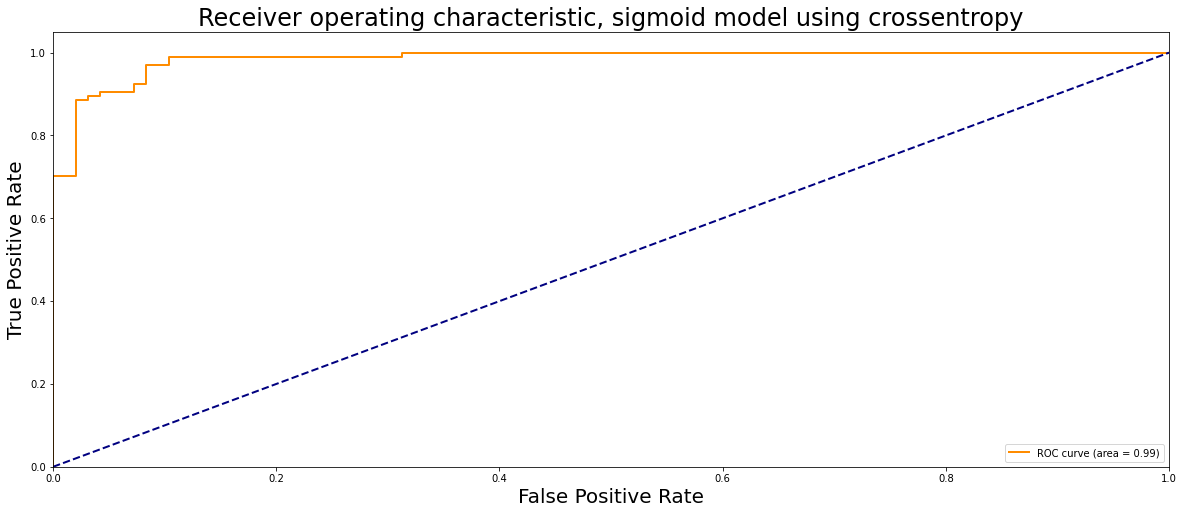

In [22]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_model_sigmoid_crossentropy)
roc_auc = auc(fpr, tpr)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic, sigmoid model using crossentropy')
plt.legend(loc="lower right");